# Title: Excersises for Chapter 13

Sanjay Jaras

## Exercise 13.1 
In NSFG Cycles 6 and 7, the variable cmdivorcx contains
the date of divorce for the respondent’s first marriage, if applicable, encoded
in century-months.
Compute the duration of marriages that have ended in divorce, and the
duration, so far, of marriages that are ongoing. Estimate the hazard and
survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from
several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and pos-
sibly by age at first marriage.

### import libraries

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
from IPython.display import set_matplotlib_formats

import nsfg
import survival
import thinkplot
import thinkstats2

plt.style.use("seaborn-darkgrid")
set_matplotlib_formats("png", "pdf")
plt.rcParams["figure.figsize"] = [16, 12]

### Read dataset

In [2]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

### Function to replace invalid values with nan and create additional columns

In [3]:
def cleanDataframe(respDf):
    respDf.cmdivorcx.replace(to_replace=[9998, 9999], value=np.nan, inplace=True)
    respDf["notdivorced"] = respDf.cmdivorcx.isnull().astype(int)
    # duration till divorce in years
    respDf["duration"] = (respDf.cmdivorcx - respDf.cmmarrhx) / 12.0
    respDf["durationsofar"] = (respDf.cmintvw - respDf.cmmarrhx) / 12.0
    # start day for century
    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in respDf.cmbirth]
    # add column for decade
    respDf["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10
    return respDf[respDf.evrmarry == 1]

### Filter un-married

In [4]:
married6 = cleanDataframe(resp6)
married7 = cleanDataframe(resp7)

### Function to group by decade and call plot

In [5]:
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        # Resample
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        # group by decade the samples
        groups = sample.groupby("decade")

        EstimateSurvivalByDecade(groups)

    legends = []
    for name, _ in groups:
        legends.append("%d0s" % name)

    plt.legend(legends)
    plt.xlabel("Years")
    plt.ylabel("Fraction undivorced")
    plt.axis([0, 28, 0, 1])
    plt.title("Survival Plot for Divorce")
    plt.show()

### Function for calling survival estimation by each decade group and plotting

In [6]:
def EstimateSurvivalByDecade(groups):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    # thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        xs, ys = sf.Render()
        plt.plot(xs, ys, alpha=0.5)

        # thinkplot.Plot(sf, **options)

### Function to estimate survival

In [7]:
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

### Plot Survival Plot

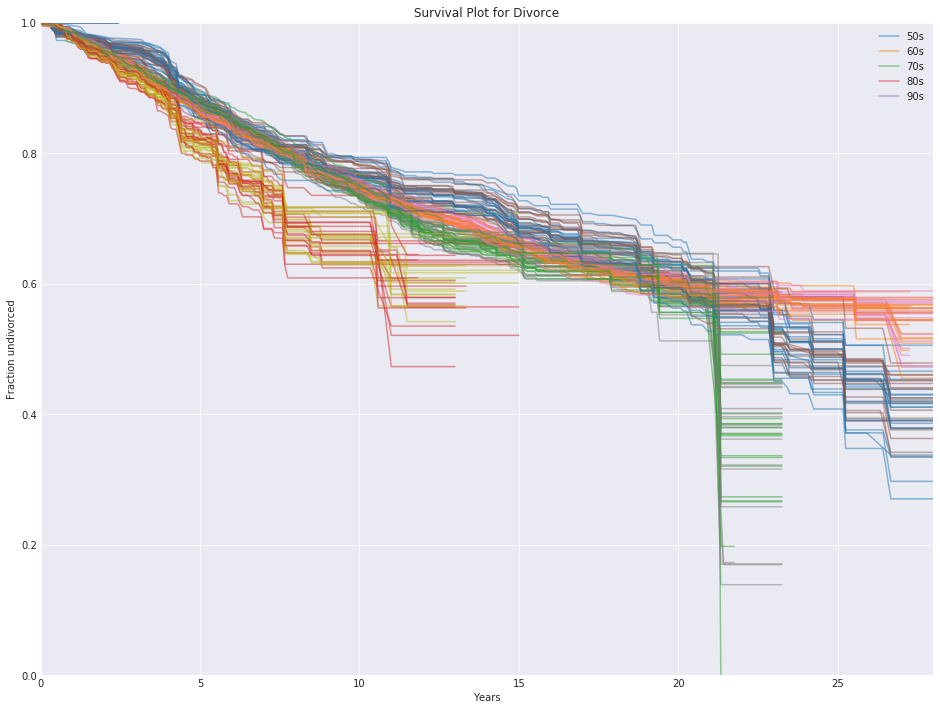

In [8]:
ResampleDivorceCurveByDecade([married6, married7])